## Anormaly detection by RockWell automation data science hackathon

This is the data science problem, the problem introduction was attached, and the data could be download here:
https://drive.google.com/open?id=1J32ICsHzggetwZbjYLGAVQ8TRL8nprjZ


## Prepare data

In [1]:
import json
import glob
import pandas as pd
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
datapath = '../Data/raw_splitfiles/'

In [2]:
# list the keys
with open("../Data/raw_splitfiles/101_0.json") as f:
    data = json.load(f)

keys = list(data[0].keys())
for i, key in enumerate(keys):
    print(str(i) + ':' + key)
del data

0:Date_Time
1:Product_ID
2:User_Name
3:bicoe_load_dttm
4:file_name
5:file_timestamp
6:hdfs_file_name
7:location
8:tooltype
9:ulCornerToleranceFailure
10:ulPossibleMissing
11:ulPurged
12:ulRejects
13:ulVPSHeightFailure
14:ulVPSPartPresenceFailure
15:ulballcountfailure
16:ulcomplocationfailure
17:ulcompmissing
18:ulcompsizefailure
19:ulcompupsidedown
20:ulfeaturecountfailure
21:ulfeaturelocationfailure
22:ulfeaturespacingfailure
23:ulleadcountfailure
24:ulleaddeviationfailure
25:ulleadlocationfailure
26:ulleadspacingfailure
27:ulleadspanfailure
28:ulorientationcheckfailure
29:ulpicks
30:ulpitchfailure
31:ulplacements
32:xml_stat_cd
33:xml_tag_id
34:xml_tag_nm


In [3]:
# get the files sorted
files = glob.glob("../Data/raw_splitfiles/*.json")
#files = sorted(files, key=lambda name: int(name[23:26])*1000+int(name[27:-5]))
# any in failure_list not equal 0, then failure = 1
failure_list = [10,13,14,15,16,18,20,23,24,26]

In [4]:
# read the data from json file to dataframe
import datetime
d = {}
d['Date_Time'] = []
d['machine_id'] = []
d['manu_id'] = []
d['ulpicks'] = []
d['ulRejects'] = []
d['ulplacements'] = []
d['failure'] = []
d['location'] = []
d['id'] = []
for file in files:
    with open(file) as f:
        data_1stamp = json.load(f)
        for nozzle in data_1stamp:
            time = nozzle['Date_Time']
            date_time_obj = datetime.datetime.strptime(time.split('.')[0], '%Y-%m-%dT%H:%M:%S')
            d['Date_Time'].append(date_time_obj)
            d['ulpicks'].append(int(nozzle['ulpicks']))
            d['ulRejects'].append(int(nozzle['ulRejects']))
            d['ulplacements'].append(int(nozzle['ulplacements']))
            failure = 0
            for i in failure_list:
                key = keys[i]
                if nozzle[key]:
                    failure = 1
            d['failure'].append(failure)
            xml = nozzle['xml_tag_nm'].split('-')
            d['machine_id'].append(xml[3])
            d['manu_id'].append(xml[2])
            d['location'].append(nozzle['location'])
            d['id'].append(xml[2] +'-'+ xml[3]+'-' + nozzle['location'])

            

In [5]:
# sort the data by time
df = pd.DataFrame(data=d)
df = df.sort_values(by=['Date_Time'])
df = df.reset_index(drop=True)

In [6]:
# show the data
df

,Date_Time,machine_id,manu_id,ulpicks,ulRejects,ulplacements,failure,location,id
0,2019-10-28 09:17:54,gc3,meq,7,0,7,0,"0,2,32","meq-gc3-0,2,32"
1,2019-10-28 09:17:54,gc3,meq,8,0,8,0,"0,2,10","meq-gc3-0,2,10"
2,2019-10-28 09:17:54,gc3,meq,8,0,8,0,"0,2,11","meq-gc3-0,2,11"
3,2019-10-28 09:17:54,gc3,meq,8,0,8,0,"0,2,13","meq-gc3-0,2,13"
4,2019-10-28 09:17:54,gc3,meq,8,0,8,0,"0,2,14","meq-gc3-0,2,14"
...,...,...,...,...,...,...,...,...,...
393128,2019-11-26 03:15:02,gc5,twb,108,0,107,0,"0,3,11","twb-gc5-0,3,11"
393129,2019-11-26 03:15:02,gc5,twb,119,0,119,0,"0,2,44","twb-gc5-0,2,44"
393130,2019-11-26 03:15:02,gc10,twb,17,0,17,0,"0,0,12","twb-gc10-0,0,12"
393131,2019-11-26 03:15:02,gc10,twb,22,4,18,0,"0,1,24","twb-gc10-0,1,24"


In [7]:
# select the meq-gc3 machine for the training, most of the data from the machine
df_select = df[df['machine_id'] == 'gc3']
df_select = df_select[df_select['manu_id'] == 'meq']
ids = set(df_select['id'])

In [8]:
# dictionary for recording the accumulation information
dic = {}
for key in ids:
    dic[key] = [0,0]
dic

{'meq-gc3-0,2,14': [0, 0],
 'meq-gc3-0,0,59': [0, 0],
 'meq-gc3-0,3,8': [0, 0],
 'meq-gc3-0,2,16': [0, 0],
 'meq-gc3-0,0,50': [0, 0],
 'meq-gc3-0,0,45': [0, 0],
 'meq-gc3-0,1,36': [0, 0],
 'meq-gc3-0,1,2': [0, 0],
 'meq-gc3-0,2,27': [0, 0],
 'meq-gc3-0,2,13': [0, 0],
 'meq-gc3-0,2,21': [0, 0],
 'meq-gc3-0,0,66': [0, 0],
 'meq-gc3-0,0,26': [0, 0],
 'meq-gc3-0,1,34': [0, 0],
 'meq-gc3-0,2,42': [0, 0],
 'meq-gc3-0,0,37': [0, 0],
 'meq-gc3-0,2,23': [0, 0],
 'meq-gc3-0,1,3': [0, 0],
 'meq-gc3-0,2,46': [0, 0],
 'meq-gc3-0,2,64': [0, 0],
 'meq-gc3-0,3,12': [0, 0],
 'meq-gc3-0,2,10': [0, 0],
 'meq-gc3-0,2,34': [0, 0],
 'meq-gc3-0,0,55': [0, 0],
 'meq-gc3-0,0,38': [0, 0],
 'meq-gc3-0,2,38': [0, 0],
 'meq-gc3-0,3,50': [0, 0],
 'meq-gc3-0,1,19': [0, 0],
 'meq-gc3-0,3,31': [0, 0],
 'meq-gc3-0,0,36': [0, 0],
 'meq-gc3-0,0,35': [0, 0],
 'meq-gc3-0,2,50': [0, 0],
 'meq-gc3-0,3,36': [0, 0],
 'meq-gc3-0,3,53': [0, 0],
 'meq-gc3-0,1,30': [0, 0],
 'meq-gc3-0,3,35': [0, 0],
 'meq-gc3-0,0,52': [0, 0],
 'me

In [9]:
# show the imbalance
import collections

cnt = collections.Counter(df_select['failure'])
cnt

Counter({0: 208410, 1: 1281})

In [10]:
X = []
X_fourFeatures = []
y = []
for i, row in enumerate(df_select.values):
    Date_Time,machine_id,manu_id,ulpicks,ulRejects,ulplacements,failure,location,Id = row
    dic[Id][0]+=ulRejects
    dic[Id][1]+=ulpicks
    X.append([dic[Id][0],dic[Id][0]/dic[Id][1]])
    X_fourFeatures.append([dic[Id][0],dic[Id][0]/dic[Id][1],ulRejects,ulRejects/ulpicks])
    y.append(failure)
    if failure:
        dic[Id] = [0,0]

In [11]:
# X is the original data, and X_fourFeatures is the data with more features
X = np.array(X)
X_fourFeatures = np.array(X_fourFeatures)
y = np.array(y)


## Train with the original two features

In [12]:
# train/test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (167752, 2) (167752,)
Test set: (41939, 2) (41939,)


In [13]:
# svm model 
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

/home/lingling/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Evaluate with the original two features

In [14]:
yhat = clf.predict(X_test)
yhat [0:5]

array([0, 0, 0, 0, 0])

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     41677
           1       0.00      0.00      0.00       262

    accuracy                           0.99     41939
   macro avg       0.50      0.50      0.50     41939
weighted avg       0.99      0.99      0.99     41939

Confusion matrix, without normalization
[[41677     0]
 [  262     0]]


/home/lingling/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


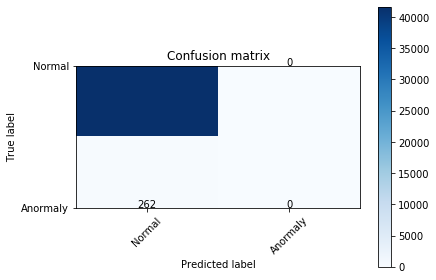

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormaly'],normalize= False,  title='Confusion matrix')

## Train with the new features

In [18]:
# train/test
X_train, X_test, y_train, y_test = train_test_split( X_fourFeatures, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (167752, 4) (167752,)
Test set: (41939, 4) (41939,)


In [19]:
from sklearn import svm
clf_fourFeatures = svm.SVC(kernel='rbf')
clf_fourFeatures.fit(X_train, y_train) 

/home/lingling/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [20]:
yhat = clf_fourFeatures.predict(X_test)
yhat [0:5]

array([0, 0, 0, 0, 0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41677
           1       0.66      0.34      0.44       262

    accuracy                           0.99     41939
   macro avg       0.83      0.67      0.72     41939
weighted avg       0.99      0.99      0.99     41939

Confusion matrix, without normalization
[[41631    46]
 [  174    88]]


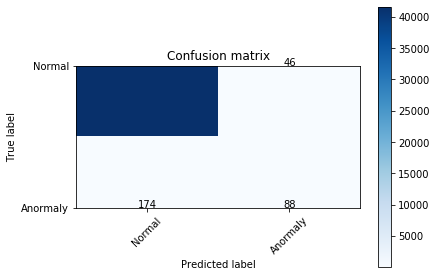

In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormaly'],normalize= False,  title='Confusion matrix')

## Train by imbalance and score ROC AUC


In [22]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC

In [23]:
# define model
model = svm.SVC(gamma='scale')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

/home/lingling/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean ROC AUC: 0.589


In [24]:
# define model
model = svm.SVC(gamma='scale')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_fourFeatures, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

# Mean ROC AUC: 0.989

Mean ROC AUC: 0.989


In [25]:
# define model
weights = {0:1.0, 1:50.0}
model = svm.SVC(gamma='scale', class_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_fourFeatures, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

/home/lingling/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean ROC AUC: 0.990


### Conclusion for the hackathon

The proposed features imporved the performance. 

This is a solution in 24 Hr, and trained by the laptop. I have to say the solution is not perfect, but it is the only solution in the 30 teams, others either didn't understand the problem or just present the idea. Unfortunately we didn't get any prize, the team present the LSTM method get the first prize, although they didn't write one row of code.